Counts of Science Keywords:
Sub-mm Galaxies (SMG)                          2718
Active Galactic Nuclei (AGN)/Quasars (QSO)     2428
High-mass star formation                       2144
Outflows                                       1872
Inter-Stellar Medium (ISM)/Molecular clouds    1759
                                               ... 
Cataclysmic stars                                11
                                                 10
Evolved stars: Shaping/physical structure         4
Exoplanets                                        2
Galaxy structure &evolution                       1
Name: count, Length: 66, dtype: int64


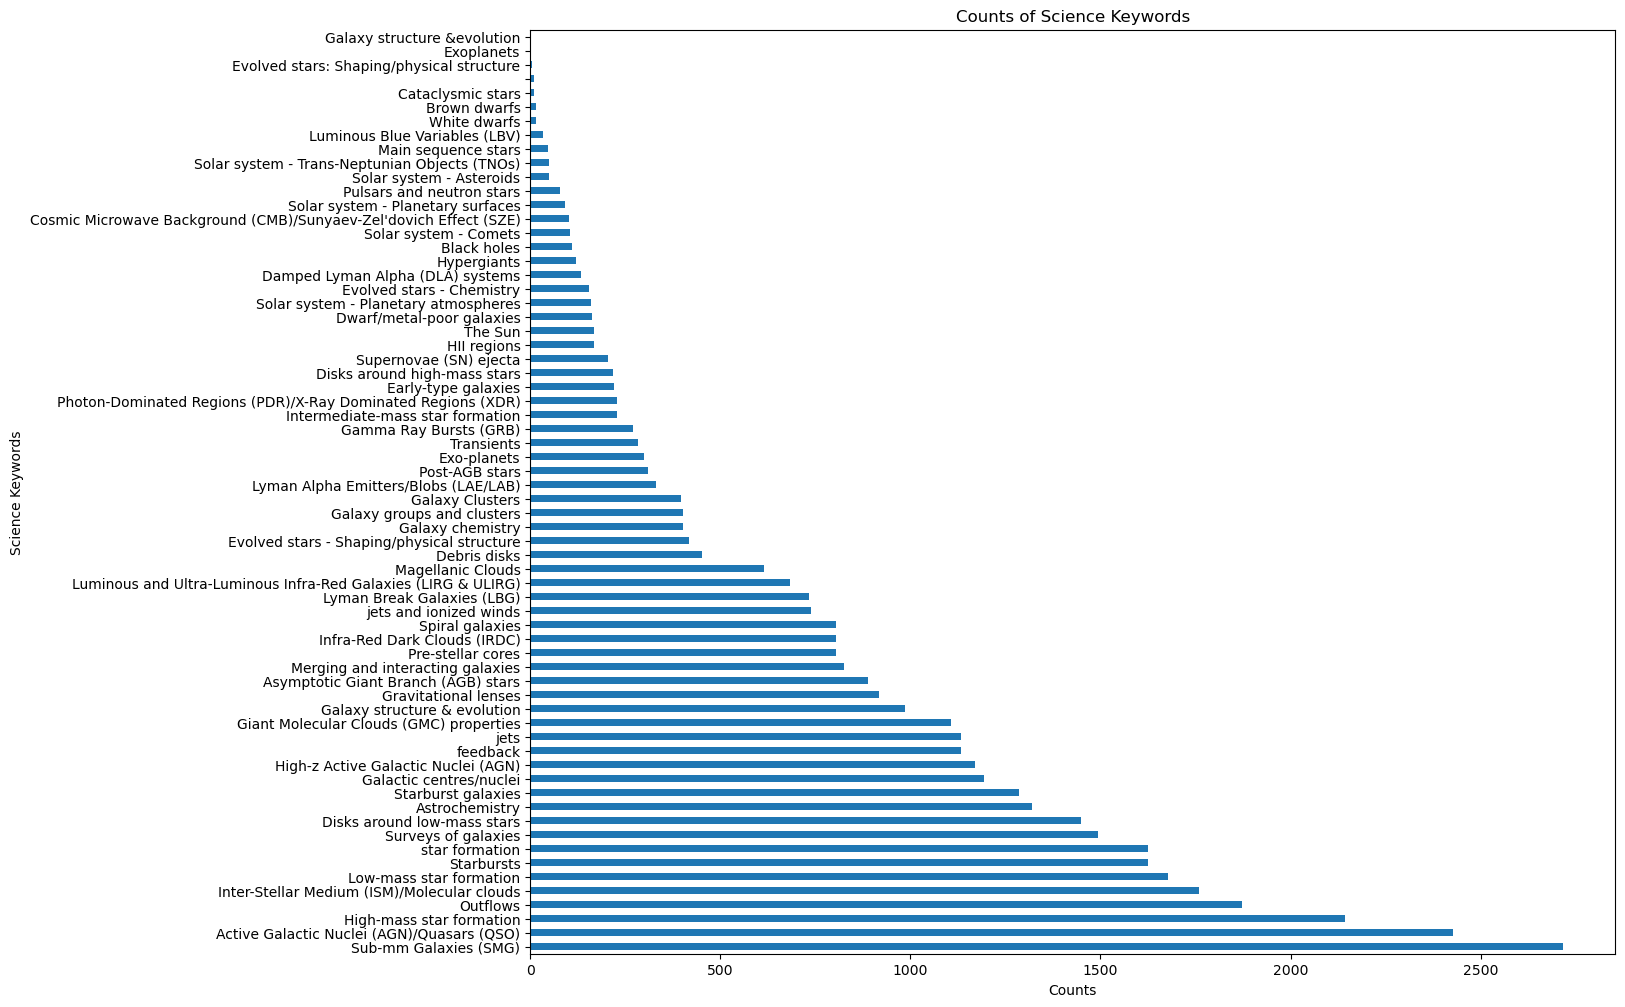

Counts of Science Keywords with ALMA Bands:
band_list                                   1  10    3    4   5    6    7   8  \
science_keyword                                                                 
                                            0   0    2    0   0    2    4   0   
Active Galactic Nuclei (AGN)/Quasars (QSO)  1   1  695  122  85  979  408  65   
Astrochemistry                              1   5  347   80  38  505  306  25   
Asymptotic Giant Branch (AGB) stars         0  11  135   22   1  505  196  11   
Black holes                                 2   0   52   18   0   28    8   0   
...                                        ..  ..  ...  ...  ..  ...  ...  ..   
White dwarfs                                0   0    3    0   3    1    9   0   
feedback                                    1   1  322   71  38  518  149  18   
jets                                        1   1  322   71  38  518  149  18   
jets and ionized winds                      0   0  132   12  15  

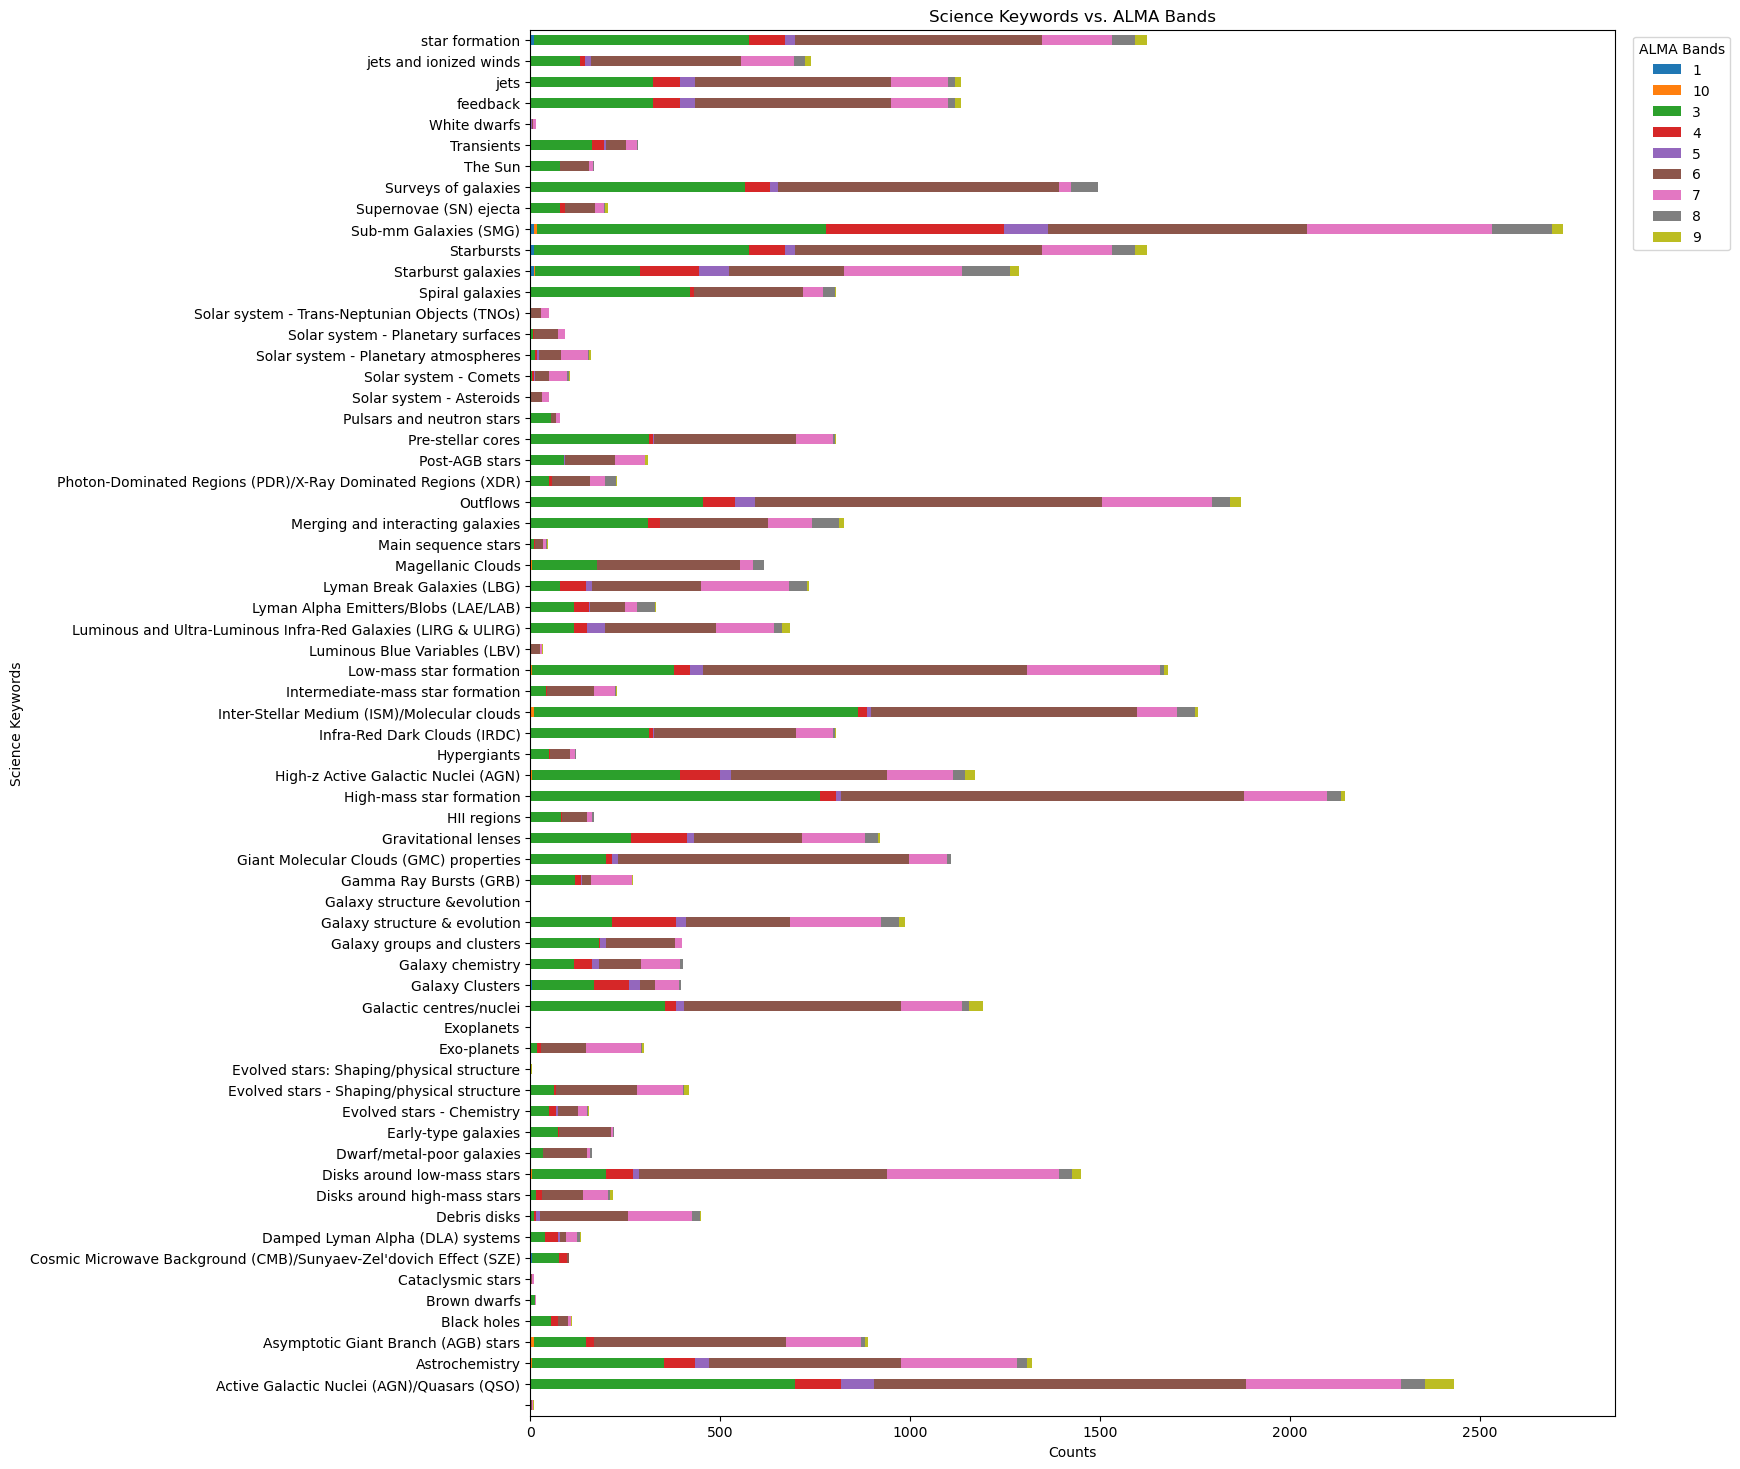

In [2]:
from astropy.constants import c
import astropy.units as U
import math
import pyvo
import numpy as np 
import pandas as pd
import os 
import sys
import matplotlib.pyplot as plt
parent_dir=os.path.dirname(os.getcwd())
def count_science_keywords(service):
    query = """  
            SELECT science_keyword, member_ous_uid
            FROM ivoa.obscore  
            WHERE science_observation = 'T'    
            """
    db = service.search(query).to_table().to_pandas()
    db = db.drop_duplicates(subset='member_ous_uid')
    science_keywords = db['science_keyword'].str.split(',', expand=True).stack().str.strip()
    science_keywords_counts = science_keywords.value_counts()
    return science_keywords_counts

service_url = "https://almascience.eso.org/tap"
service = pyvo.dal.TAPService(service_url)
    
# Count science keywords
science_keywords_counts = count_science_keywords(service)
print("Counts of Science Keywords:")
print(science_keywords_counts)
plt.figure(figsize=(14, 12))
science_keywords_counts.plot(kind='barh')
plt.title('Counts of Science Keywords')
plt.xlabel('Counts')
plt.ylabel('Science Keywords')
plt.show()
def count_science_keywords_with_bands(service):
    query = """  
            SELECT science_keyword, band_list, member_ous_uid
            FROM ivoa.obscore  
            WHERE science_observation = 'T'    
            """
    db = service.search(query).to_table().to_pandas()
    db = db.drop_duplicates(subset='member_ous_uid')
    # Splitting the science keywords at commas
    db['science_keyword'] = db['science_keyword'].str.split(',')
    
    # Exploding to have one row for each combination of science keyword and band
    db = db.explode('science_keyword')
    
    # Cleaning up science keywords and band names
    db['science_keyword'] = db['science_keyword'].str.strip()
    db['band_list'] = db['band_list'].str.split(' ')
    
    # Exploding to have one row for each combination of science keyword and band
    db = db.explode('band_list')
    
    # Cleaning up band names
    db['band_list'] = db['band_list'].str.strip()
    
    # Counting occurrences of each combination of science keyword and band
    counts = db.groupby(['science_keyword', 'band_list']).size().unstack(fill_value=0)
    return counts


service_url = "https://almascience.eso.org/tap"
service = pyvo.dal.TAPService(service_url)
    
# Count science keywords with bands
counts = count_science_keywords_with_bands(service)
print("Counts of Science Keywords with ALMA Bands:")
print(counts)

plt.rcParams["figure.figsize"] = (14,18)
counts.plot(kind='barh', stacked=True)
plt.title('Science Keywords vs. ALMA Bands')
plt.xlabel('Counts')
plt.ylabel('Science Keywords')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left',title='ALMA Bands')
plt.show()  

In [3]:
pd.set_option('display.max.rows', None)
pd.set_option('display.max.columns', None)
counts

band_list,1,10,3,4,5,6,7,8,9
science_keyword,,,,,,,,,
,0,0,2,0,0,2,4,0,3
Active Galactic Nuclei (AGN)/Quasars (QSO),1,1,695,122,85,979,408,65,77
Astrochemistry,1,5,347,80,38,505,306,25,15
Asymptotic Giant Branch (AGB) stars,0,11,135,22,1,505,196,11,8
Black holes,2,0,52,18,0,28,8,0,3
Brown dwarfs,0,0,12,0,0,1,2,0,0
Cataclysmic stars,0,0,1,2,0,3,5,0,0
Cosmic Microwave Background (CMB)/Sunyaev-Zel'dovich Effect (SZE),5,0,72,21,0,4,1,0,0
Damped Lyman Alpha (DLA) systems,0,0,40,32,6,17,27,9,2
